In [53]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.svm import SVC, SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import (
 cross_val_score,
 cross_validate,
 train_test_split,
 GridSearchCV,
 RandomizedSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
import shap
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')


RendererRegistry.enable('mimetype')

### Transform data 

In [2]:
X_train = pd.read_csv("../data/raw/X_train.csv", parse_dates=['year'])
X_train['year'] = X_train['year'].dt.year
y_train = pd.read_csv("../data/raw/y_train.csv")
train_df = X_train.join(y_train.set_index('carID'), on = "carID")

In [3]:
train_df.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         4960 non-null   int64  
 1   brand         4960 non-null   object 
 2   model         4960 non-null   object 
 3   year          4960 non-null   int64  
 4   transmission  4960 non-null   object 
 5   mileage       4960 non-null   int64  
 6   fuelType      4960 non-null   object 
 7   tax           4960 non-null   float64
 8   mpg           4960 non-null   float64
 9   engineSize    4960 non-null   float64
 10  price         4960 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 426.4+ KB


In [5]:
drop_features = ["carID"]
categorical_features = ["brand", "model", "year", "transmission", "fuelType"]
target = "price"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set(categorical_features)
    - set([target])
)
assert train_df.columns.shape[0] == len(
    drop_features
    + categorical_features
    + numeric_features
    + [target]
)

In [6]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    ("drop", drop_features))

In [7]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]

In [8]:
scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2"}

In [9]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['mileage', 'mpg', 'engineSize', 'tax']),
                                ('onehotencoder',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['brand', 'model', 'year', 'transmission',
                                  'fuelType']),
                                ('drop', 'drop', ['carID'])])

### Models

#### baseline

In [10]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [11]:
results ={}

In [12]:
dummy = DummyRegressor()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

In [13]:
pd.DataFrame(results)

,Dummy
fit_time,0.002 (+/- 0.002)
score_time,0.001 (+/- 0.001)
test_neg RMSE,-16394.964 (+/- 837.605)
train_neg RMSE,-16403.194 (+/- 211.166)
test_r2,-0.003 (+/- 0.002)
train_r2,0.000 (+/- 0.000)


In [14]:
pipe_lr = make_pipeline(
    preprocessor, Ridge(random_state=123)
)

pipe_ls = make_pipeline(
    preprocessor, Lasso(random_state=123)
)

pipe_rf = make_pipeline(
    preprocessor, RandomForestRegressor(random_state=123)
)

pipe_catboost = make_pipeline(
    preprocessor, CatBoostRegressor(random_state=123, verbose = 0)
)

In [15]:
models = {
    "linear regression": pipe_lr,
    "lasso": pipe_ls,
    "random forest": pipe_rf,
    "CatBoost": pipe_catboost
}

In [16]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

In [17]:
pd.DataFrame(results)

,Dummy,linear regression,lasso,random forest,CatBoost
fit_time,0.002 (+/- 0.002),0.028 (+/- 0.007),0.725 (+/- 0.136),7.609 (+/- 0.506),1.979 (+/- 0.329)
score_time,0.001 (+/- 0.001),0.007 (+/- 0.000),0.008 (+/- 0.001),0.042 (+/- 0.004),0.019 (+/- 0.009)
test_neg RMSE,-16394.964 (+/- 837.605),-5179.866 (+/- 365.046),-5167.081 (+/- 349.605),-3833.320 (+/- 176.925),-3258.583 (+/- 203.897)
train_neg RMSE,-16403.194 (+/- 211.166),-4996.577 (+/- 84.803),-4963.956 (+/- 84.650),-1514.788 (+/- 49.437),-2208.328 (+/- 18.898)
test_r2,-0.003 (+/- 0.002),0.900 (+/- 0.007),0.900 (+/- 0.008),0.945 (+/- 0.002),0.960 (+/- 0.005)
train_r2,0.000 (+/- 0.000),0.907 (+/- 0.002),0.908 (+/- 0.002),0.991 (+/- 0.001),0.982 (+/- 0.001)


In [18]:
pipe_catboost.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['mileage', 'mpg',
                                                   'engineSize', 'tax']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['brand', 'model', 'year',
                                                   'transmission',
                                                   'fuelType']),
                                                 ('drop', 'drop', ['carID'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x141b8cc70>)])

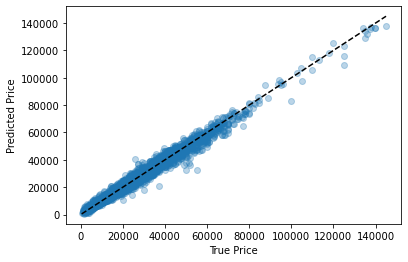

In [19]:
plt.scatter(y_train, pipe_catboost.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("True Price")
plt.ylabel("Predicted Price");

In [20]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['mileage', 'mpg', 'engineSize', 'tax']),
                                ('onehotencoder',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['brand', 'model', 'year', 'transmission',
                                  'fuelType']),
                                ('drop', 'drop', ['carID'])])

In [21]:
feature_names = (
    numeric_features
    + list(
        pipe_lr.named_steps["columntransformer"]
        .named_transformers_["onehotencoder"]
        .get_feature_names_out()
    ))

In [24]:
X_train_encode = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_encode.head()

,mileage,mpg,engineSize,tax,brand_audi,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,...,year_2020,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,-0.848304,-0.295744,0.095814,-0.088993,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.937516,0.272200,-0.157579,-0.331725,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.810335,-0.595105,0.982689,-0.088993,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.185480,0.202256,-0.157579,-1.484700,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.875062,-0.091508,-1.424542,-0.088993,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [25]:
pipe_catboost.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['mileage', 'mpg',
                                                   'engineSize', 'tax']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['brand', 'model', 'year',
                                                   'transmission',
                                                   'fuelType']),
                                                 ('drop', 'drop', ['carID'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x141b8cc70>)])

In [26]:
catboost_explainer = shap.TreeExplainer(pipe_catboost.named_steps["catboostregressor"])
train_catboost_shap_values = catboost_explainer.shap_values(X_train_encode)

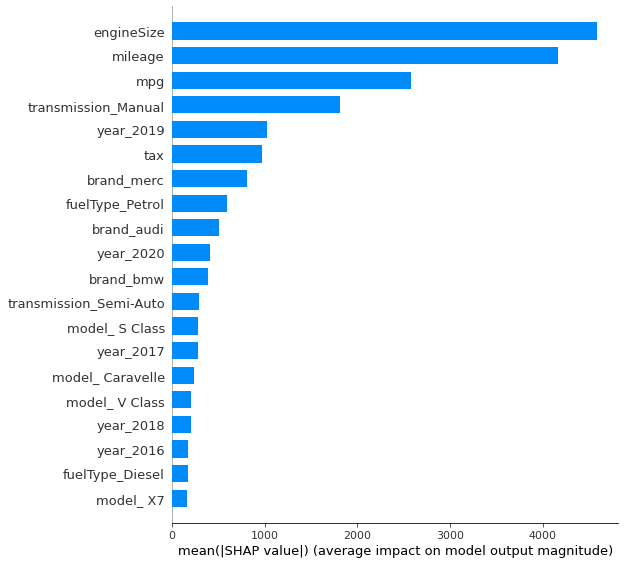

In [27]:
shap.summary_plot(train_catboost_shap_values, X_train_encode, plot_type="bar")

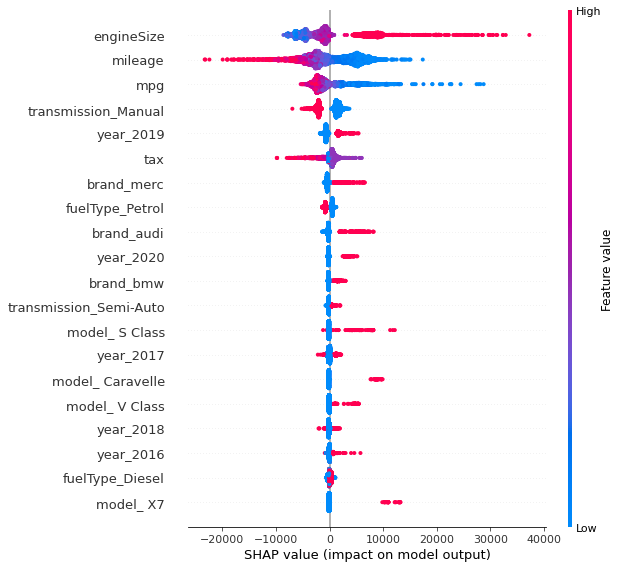

In [28]:
shap.summary_plot(train_catboost_shap_values, X_train_encode)

In [39]:
X_test = pd.read_csv("../data/raw/X_test.csv", parse_dates=['year'])
X_test['year'] = X_test['year'].dt.year
y_test = pd.read_csv("../data/raw/y_test.csv")

In [40]:
X_test_encode = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)

In [41]:
test_catboost_shap_values = catboost_explainer.shap_values(X_test_encode)

In [42]:
X_test_encode = X_test_encode.round(2)

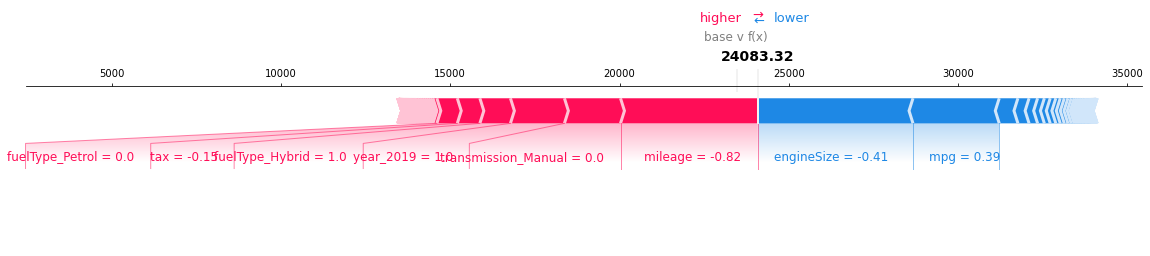

In [43]:
shap.force_plot(
    catboost_explainer.expected_value,
    test_catboost_shap_values[8],
    X_test_encode.loc[8, :],
    matplotlib=True,
)

In [50]:
y_predict = pipe_catboost.predict(X_test)

In [55]:
y_predict

array([40661.63023434, 24844.15085323, 56554.81495673, ...,
       21345.91145177, 20662.7712638 , -1560.38596161])

In [59]:
r2_score(y_test['price'], y_predict)

0.9559206801347232